In [169]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import os
import re
import shutil

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import export_graphviz
import graphviz

%matplotlib inline
matplotlib.use('module://ipykernel.pylab.backend_inline')


In [170]:
n_samples =None # if none, then all data points of the data set will be loaded
remove_na = True 


gender_column = "Sex"
gender = None
iqr_coefficient = None # if None, no oulier removing is performed prior to model building

outcome = "Diabetes_012" 

home_directory = os.path.expanduser("~")
working_dir = f"{home_directory}/PRIME/example_data" # sets the working directory where the input output files are written in

# https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators
# https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?resource=download
input_file = f"{working_dir}/diabetes_012_health_indicators_BRFSS2015.csv"

# creating output directory based on outcome name and gender if given
outcome_dir = outcome.replace(',', '_').replace('/', '_').replace(' ', '')

output_dir = f"{working_dir}/tree_{outcome_dir}"

if gender is None:
  output_dir = f"{output_dir}/"
else:
  output_dir = f"{output_dir}_gender_{gender_column}/"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)


predictors = ["Sex",  "Age", "HighBP", "HighChol", "CholCheck", "BMI","Smoker", "Stroke", 
              "HeartDiseaseorAttack", "MentHlth", "PhysActivity", "DiffWalk", "Fruits", "Veggies", "HvyAlcoholConsump",
              "Education", "Income"]
simple_predictors = ["Age", "BMI"]




# tree-building algorithm specific parameters
m_samples_split = 500
m_samples_leaf = 250
m_depth = 6

RANDOM_STATE_SPLIT = 13
RANDOM_STATE_REGR = 42

stratify = True
# parameters to set up selection of training and validation sets
# these parameters, together woth random parameters above can be adjusted to discover stability of the model
percentage_test = 0.25 # percentage of teh data points in the validation set
n_splits = 4 # bumber of 
n_fold = 1 # the index of the fold you want to use in the stratified train and test split, when building a model
quantiles = [0.2, 0.4, 0.6, 0.8, 1] # for non-categorical data, you need to set up which quantiles you want to use for stratified train-test split 

# list categorical predictors to assist stratification for a training set
# In the running example dataset all the predictors except BMI, Mental Health (count depressed or stressed days last month) and age are categorical
# Remark: in the description of the data set it is stated that age is also splitted by categories
# but since the number of categories is quite high, exceeds 10, we suggest consider 'age' as a non-categorical field
cat_predictors = ["Sex",  "Education", "Income", "HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", 
              "HeartDiseaseorAttack", "PhysActivity", "DiffWalk", "Fruits", "Veggies", "HvyAlcoholConsump", 
             "AnyHealthcare", "NoDocbcCost"]

In [171]:
# this functuib used to obtain stratified train-test split, 
# that is, the algorithm will do its bets to assure that, for instance, the percentage of women with highest education level of age Quartile Q2 is the same in the trainig set as in the whole population
# in this way training set reflects the whole population structure better
# however when the number of predictors is high it gets difficult to assure that will will have enough data points for each fine subcategory. In this case the algorithm ignore the  refinement of such small subcategory.
def my_stratification(df_, fld_name, quantiles, lim, global_strat):
   
    first = False
    df_ = df_.assign(**{"combined_labe_test": ""})
    if "combined_label" not in df_.columns: 
        df_ = df_.assign(**{"combined_label": ""})
        first = True
    if quantiles is None:
        if first:
            df_["combined_label"] = df_[fld_name].astype(int).astype(str)
            print(fld_name)
        else:
            df_["combined_label_test"] = df_["combined_label"]+"_"+df_[fld_name].astype(int).astype(str)
            values_combined_label_test = df_["combined_label_test"].drop_duplicates().tolist()
            
            if len(values_combined_label_test) > lim:
                df_ = df_.drop(columns=["combined_label_test"], axis=1)
                return df_
            
            enough = True
            
            for i in range(len(values_combined_label_test)):
                lab_val = values_combined_label_test[i]
                df_tmp = df_[df_["combined_label_test"].eq(lab_val)]
                if len(df_tmp) < 2:
                    # will merge this and next one some we will have more values in the extended bin
                    if i< len(values_combined_label_test) - 1:
                        df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i+1]
                    else:
                        # try merge with the previous
                        if i>0:
                            df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i-1]
                            df_tmp = df_[df_["combined_label_test"].eq(values_combined_label_test[i-1])]
                            if len(df_tmp) < 2:
                                enough = False
                                break
                            else:
                                values_combined_label_test[i] = values_combined_label_test[i-1]
                        else:
                            enough = False
                            break
                             
                        
                    
            if enough:
                df_["combined_label"] = df_["combined_label_test"]
                print(fld_name)
            
            df_ = df_.drop(columns=["combined_label_test"], axis=1)
                
    else: # quantiles
        df_ = df_.assign(**{"tmp": 0})
         
        if global_strat:
            qw =np.zeros(len(quantiles))
            for i in range(len(quantiles)):
                qw[i] = df_[fld_name].quantile(quantiles[i])
                
            df_.loc[df_[fld_name].le(qw[0]), "tmp"] = 1
            for i in range(1, len(quantiles)):
                df_.loc[df_[fld_name].gt(qw[i-1])& df_[fld_name].le(qw[i]), "tmp"] = i+1
            
        else: # local qunatile per per bin
            values_combined_label = df_["combined_label"].drop_duplicates().tolist()
            for lab_val in values_combined_label:
                df_tmp = df_[df_["combined_label"].eq(lab_val)]
                qw = np.zeros(len(quantiles))
                for i in range(len(quantiles)):
                    qw[i] = df_tmp[fld_name].quantile(quantiles[i])
                
                df_.loc[df_["combined_label"].eq(lab_val) & df_[fld_name].le(qw[0]), "tmp"] = 1
                for i in range(1, len(quantiles)):
                    df_.loc[df_["combined_label"].eq(lab_val) & df_[fld_name].gt(qw[i-1])& df_[fld_name].le(qw[i]), "tmp"] = i+1
        
        if first:
            df_["combined_label_test"] = df_["tmp"].astype(str)
        else:
            df_["combined_label_test"] = df_["combined_label"]+"_"+df_["tmp"].astype(str)
        df_ = df_.drop(columns=["tmp"], axis=1)
        values_combined_label_test = df_["combined_label_test"].drop_duplicates().tolist()
        
        if len(values_combined_label_test) > lim: # the number of classes exceeds the number of test points
            df_ = df_.drop(columns=["combined_label_test"], axis=1)
            return df_
        
        enough = True
        
        for i in range(len(values_combined_label_test)):
            lab_val = values_combined_label_test[i]
            df_tmp = df_[df_["combined_label_test"].eq(lab_val)]
            if len(df_tmp) < 2:
                # will merge this and next one some we will have more values in the extended bin
                if i< len(values_combined_label_test) - 1:
                    df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i+1]
                else:
                    # try merge with the previous
                    if i>0:
                        df_.loc[df_["combined_label_test"].eq(lab_val), "combined_label_test"] = values_combined_label_test[i-1]
                        df_tmp = df_[df_["combined_label_test"].eq(values_combined_label_test[i-1])]
                        if len(df_tmp) < 2:
                            enough = False
                            break
                        else:
                            values_combined_label_test[i] = values_combined_label_test[i-1]
                    else:
                        enough = False
                        break
                            
            
        if enough:
            print(fld_name)
            df_["combined_label"] = df_["combined_label_test"]
       
        df_ = df_.drop(columns=["combined_label_test"], axis=1)
    return df_
            
        

In [172]:
# function for removing outliers via iqr approach
def remove_outliers_iqr(df_, iqr_cf,  outliers):
    print(f"# data points before removing outliers: {len(df_)}")
    if iqr_cf is not None:
        
        lower_bound = {}
        upper_bound = {}
        
        for feat  in outliers:
            print(f"{feat}")
            
            Q1 = df_[feat].quantile(0.25)
            Q3 = df_[feat].quantile(0.75)
            
            IQR = Q3-Q1
            lower_bound[feat] = Q1 - iqr_cf * IQR
            upper_bound[feat] = Q3 + iqr_cf * IQR
            
            
            
        for feat in lower_bound:
            df_= df_[(df_[feat] >= lower_bound[feat]) & (df_[feat] <= upper_bound[feat])]
            
        print(f"# data points after removing outliers: {len(df_)}")
    return(df_)

In [173]:
df = pd.read_table(input_file, nrows=n_samples,sep =",")
df = df[predictors+[outcome]]


In [174]:
print(f"data set {len(df)} rows")
if remove_na:
    df = df.dropna(axis="rows")
    print(f"cleaned check up db has {len(df)} rows")


data set 253680 rows
cleaned check up db has 253680 rows


In [175]:
 
if gender is not None:
   df = df[df[gender_column].eq(gender) ]
   predictors.remove(gender_column)
   df = df.drop(columns=[gender_column], axis=1)
       
df = remove_outliers_iqr(df, iqr_coefficient, df.columns) 

# data points before removing outliers: 253680


In [176]:
features = [x for x in df.columns if x not in [outcome]]

In [177]:
print(features)
df = df.reset_index()

['Sex', 'Age', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'MentHlth', 'PhysActivity', 'DiffWalk', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'Education', 'Income']


In [178]:
if stratify:
    vars = features

    lim_ = percentage_test * len(df)
    global_stratification = False

    for clmn in vars:
    
        if clmn in cat_predictors:
            df = my_stratification(df, clmn, None, lim_, global_stratification)
        else:
            df = my_stratification(df, clmn, quantiles, lim_, global_stratification)

    values_combined_label = df["combined_label"].drop_duplicates().tolist()

    features_stratify = features + ["combined_label"]
    X = df[features_stratify]
    y = df[outcome]


    init_stratified_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=percentage_test,random_state=RANDOM_STATE_SPLIT )
    train_valid_rows = init_stratified_split.split(X, X["combined_label"])

    # for conveniense: order train-validation pairs into array
    X_train_list = []
    X_valid_list = []
    y_train_list = []
    y_valid_list = []

    for fold, (train_index, valid_index) in enumerate(train_valid_rows):
        print(f"Fold {fold+1}")
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        X_train_list.append(X_train)
        X_valid_list.append(X_valid)
        
        y_train, y_valid = y.loc[train_index], y.loc[valid_index]
        y_train_list.append(y_train)
        y_valid_list.append(y_valid)
        

    # th combined lable is not needed for analysis any more
    df= df.drop(columns=["combined_label"], axis=1)
    # pick up the ftrain-validation pair you want to work with, by fold index
    X_train = X_train_list[n_fold][features]
    y_train = y_train_list[n_fold]

    X_val = X_valid_list[n_fold][features]
    y_val = y_valid_list[n_fold]

else:
    X_train, X_val, y_train, y_val = train_test_split(df[features], df[outcome], test_size = percentage_test, random_state = RANDOM_STATE_SPLIT)
    

Sex
Age
HighBP
HighChol
CholCheck
BMI
Smoker
Stroke
HeartDiseaseorAttack
MentHlth
PhysActivity
DiffWalk
Fruits
Veggies
HvyAlcoholConsump
Fold 1
Fold 2
Fold 3
Fold 4


In [179]:
# build a linear model based on simple predictors
scaler_simple = StandardScaler()

X_train_simple = X_train[simple_predictors]
X_val_simple = X_val[simple_predictors]

X_train_simple_scaled = scaler_simple.fit_transform(X_train_simple)
X_val_simple_scaled = scaler_simple.transform(X_val_simple)

model_simple = LinearRegression()
model_simple.fit(X_train_simple_scaled, y_train)
       
y_simple_pred_train = model_simple.predict(X_train_simple_scaled)   

mae_simple_tr = mean_absolute_error(y_train, y_simple_pred_train)
mse_simple_tr = mean_squared_error(y_train, y_simple_pred_train)
rmse_simple_tr = mean_squared_error(y_train, y_simple_pred_train, squared=False)  # RMSE is the square root of MSE
r2_simple_tr = r2_score(y_train, y_simple_pred_train)

validation_summary = f"Train mean_absolute_error  { mae_simple_tr}\n" 
validation_summary += f"Train simple model root mean_squared_error  {rmse_simple_tr}\n"
validation_summary += f"Train simple model R-squared (the coefficient of determination) {r2_simple_tr}\n"


 
y_simple_pred_val = model_simple.predict(X_val_simple_scaled)

mae_simple = mean_absolute_error(y_val, y_simple_pred_val)
mse_simple = mean_squared_error(y_val, y_simple_pred_val)
rmse_simple = mean_squared_error(y_val, y_simple_pred_val, squared=False)  # RMSE is the square root of MSE
r2_simple = r2_score(y_val, y_simple_pred_val)
   

validation_summary += f"vaidation simple model mean_absolute_error  { mae_simple}\n"
validation_summary += f"vaidation simple model root mean_squared_error  {rmse_simple}\n"
validation_summary += f"vaidation simple model R-squared (the coefficient of determination) {r2_simple}\n"
    
print(validation_summary)

Train mean_absolute_error  0.466005009243186
Train simple model root mean_squared_error  0.6652891496408007
Train simple model R-squared (the coefficient of determination) 0.08843884022258752
vaidation simple model mean_absolute_error  0.4705452556568067
vaidation simple model root mean_squared_error  0.6714281648072525
vaidation simple model R-squared (the coefficient of determination) 0.08561614771471537



In [180]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
min_ = df[outcome].min()
max_ = df[outcome].max()
median_ = df[outcome].median()
mean_ = df[outcome].mean()
print(f"tr min {outcome}: {min_}")
print(f"tr max {outcome}: {max_}")
print(f"tr median {outcome}: {median_}")
print(f"tr mean {outcome}: {mean_}")

train samples: 190260
validation samples: 63420
tr min Diabetes_012: 0.0
tr max Diabetes_012: 2.0
tr median Diabetes_012: 0.0
tr mean Diabetes_012: 0.29692131819615264


In [181]:
# computed difference between the ground truth outcome and simple prediction
y_train_residuals =  y_train - y_simple_pred_train
y_valid_residuals =  y_valid - y_simple_pred_val


In [182]:
# consider only predictors which are not in simple predictors
factors = [item for item in predictors if item not in simple_predictors]
print(factors)
X_train_rest = X_train[factors ]
X_val_rest = X_val[factors]

['Sex', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'MentHlth', 'PhysActivity', 'DiffWalk', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'Education', 'Income']


In [183]:
# build a linear model for the residuals after regressing the simple prediction out of the ground truth outcome
scaler_lm = StandardScaler()
X_train_scaled = scaler_lm.fit_transform(X_train_rest)
X_val_scaled = scaler_lm.transform(X_val_rest)
    
    # main model    
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train_residuals)
    
y_pred_residuals_train = lin_model.predict(X_train_scaled)
y_pred_residuals_val = lin_model.predict(X_val_scaled)
 
# claculate metrics for validation  
mae = mean_absolute_error(y_valid_residuals, y_pred_residuals_val)
mse = mean_squared_error(y_valid_residuals, y_pred_residuals_val)
rmse = mean_squared_error(y_valid, y_pred_residuals_val, squared=False)  # RMSE is the square root of MSE
r2 = r2_score(y_valid_residuals, y_pred_residuals_val)
    
validation_summary = f"vaidation mean_absolute_error  { mae}\n"
validation_summary += f"vaidation root mean_squared_error  {rmse}\n"
validation_summary += f"vaidation R-squared (the coefficient of determination) {r2}\n"

# Extract parameters
intercept = lin_model.intercept_
coefficients = lin_model.coef_

# Calculate metrics for t
# raining
mse_tr= mean_squared_error(y_train_residuals, y_pred_residuals_train)
r2_tr = r2_score(y_train_residuals, y_pred_residuals_train)

# Print training summary
print("Linear Regression Summary for training:")
print("==========================")
print(f"Intercept training: {intercept}")
print(f"Coefficients: {coefficients}")
print(f"Mean Squared Error training: {mse_tr}")
print(f"R-squared traing: {r2_tr}")

print("validation summary")
print(validation_summary)

Linear Regression Summary for training:
Intercept training: 1.822014327385143e-17
Coefficients: [ 0.02056166  0.05869996  0.05091457  0.01645973 -0.00515647  0.01769227
  0.04103748  0.01927845 -0.00817172  0.04259126 -0.0082542  -0.00524713
 -0.02097787 -0.01337784 -0.03707379]
Mean Squared Error training: 0.416114991868715
R-squared traing: 0.05986010608590597
validation summary
vaidation mean_absolute_error  0.541281500573211
vaidation root mean_squared_error  0.774882391531706
vaidation R-squared (the coefficient of determination) -0.1072508232360776



In [184]:
# build a regression-tree nodel for the residuals after regressing the simple prediction out of the ground truth outcome
# note that the still consider ALL predictors, inculding simple ones, due to the fact that simple linear model could miss nonlinear dependencies on simple predictors!

specific_name = f"tree_for_residuals_{outcome_dir}_{m_samples_split}_{m_samples_leaf}_{m_depth}_{RANDOM_STATE_REGR}_fold_{n_fold}"

regressor = DecisionTreeRegressor(min_samples_leaf = m_samples_leaf,
                                  min_samples_split =  m_samples_split,
                                  max_depth = m_depth,
                                  random_state = RANDOM_STATE_REGR)

regression_tree_model = regressor.fit(X_train,y_train_residuals)
tree_pred_train_residuals = regression_tree_model.predict(X_train)
tree_pred_valid_residuals = regression_tree_model.predict(X_val)

print(f"MAE train:\n\t: {mean_absolute_error(tree_pred_train_residuals,y_train_residuals):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(tree_pred_valid_residuals,y_valid_residuals):.4f}")

print(f"RMSE train:\n\t: {np.sqrt(mean_squared_error(tree_pred_train_residuals,y_train_residuals)):.4f}")
print(f"RMSE validation:\n\t: {np.sqrt(mean_squared_error(tree_pred_valid_residuals,y_valid_residuals)):.4f}")

print(f"r2 train:\n\t: { r2_score(y_train_residuals, tree_pred_train_residuals):.4f}")
print(f"r2 validation:\n\t: {r2_score(y_valid_residuals, tree_pred_valid_residuals):.4f}")


MAE train:
	: 0.4197
MAE validation:
	: 0.5058
RMSE train:
	: 0.6367
RMSE validation:
	: 0.7570
r2 train:
	: 0.0841
r2 validation:
	: -0.0840


In [185]:
def show_importances(tree_model,name):
    

    # Retrieve the feature importances
    importances = tree_model.feature_importances_

    # Print the feature importances
    important_features = []
    important_importances = []
    df_importances = pd.DataFrame()

    for feature_name, importance in zip(features, importances):
        if importance > 0:
            important_features.append(feature_name)
            important_importances.append(importance)
            new_row = {'feature': feature_name, 'importance': importance}
            new_row_df = pd.DataFrame([new_row])
            df_importances = pd.concat([df_importances, new_row_df], ignore_index=True)
            
    print(df_importances)       
    df_importances.to_csv(f"{output_dir}/feature_importance_{specific_name}.csv", sep =",")
    # Visualize the feature importances
    plt.figure(figsize=(10, 10))
    plt.barh(important_features, important_importances, align='center')
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importances in DecisionTreeRegressor {name}")
    file_path = os.path.join(output_dir, 'feature_importances.png')
    plt.savefig(file_path)
    plt.show()


                feature  importance
0                   Sex    0.006332
1                   Age    0.105559
2                HighBP    0.310494
3              HighChol    0.152697
4                   BMI    0.153268
5                Stroke    0.002724
6  HeartDiseaseorAttack    0.049795
7              DiffWalk    0.174237
8     HvyAlcoholConsump    0.010018
9                Income    0.034875


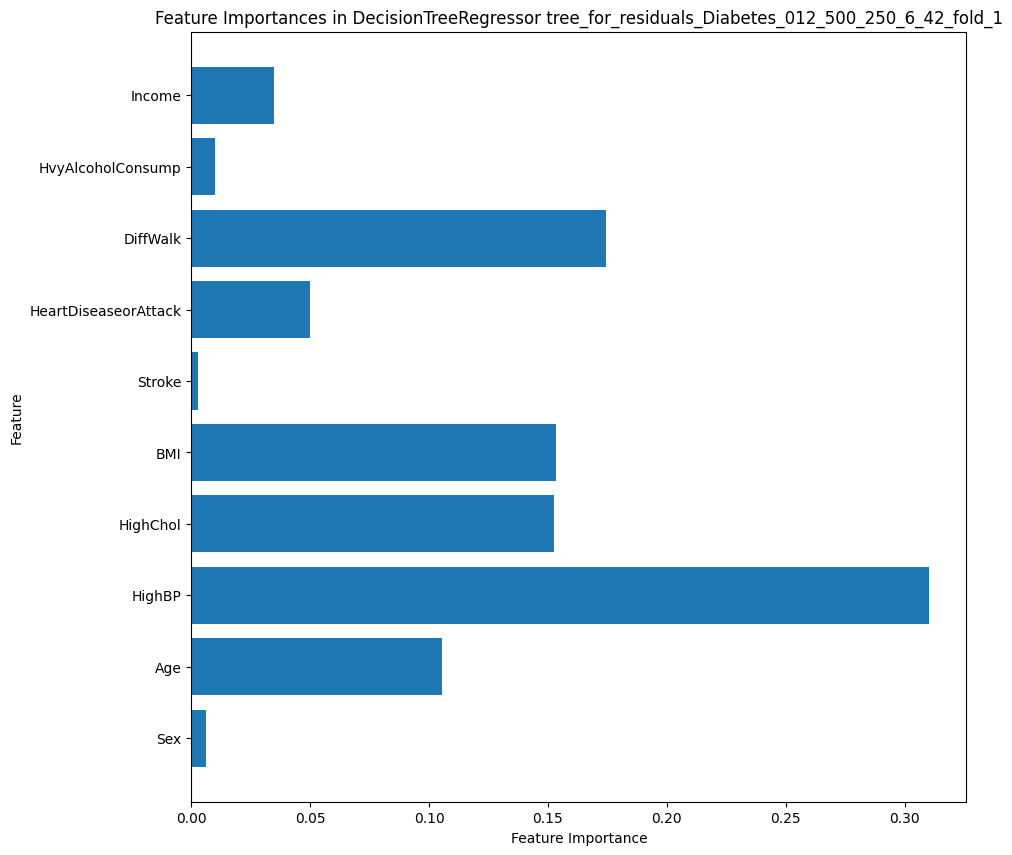

In [186]:
show_importances(regression_tree_model, specific_name)

In [187]:
def show_tree(regrsr, ft, name):
# adjusting colors
    values = regrsr.tree_.value.flatten()
    # Normalize the values for coloring
    norm = plt.Normalize(values.min(), values.max())
    # Create a custom color map (green to red)
    cmap = mcolors.LinearSegmentedColormap.from_list("GreenYellowRed", ["green", "yellow", "red"])

    # Generate colors for each node based on the normalized values and the custom color map
    colors = cmap(norm(values))

    dot_data_1 = export_graphviz(regrsr,  out_file=None, filled=True, rounded=True, special_characters=True,
                            feature_names=ft,
                            proportion=True)


    # Split the DOT data into lines
    dot_lines = dot_data_1.splitlines()
    hex_color_pattern = r'fillcolor="#[0-9a-fA-F]{6}"'

    # Modify the DOT file lines to include custom colors
    new_dot_lines = []
    for line in dot_lines:
        if 'fillcolor' in line:
            parts = line.split()
            if parts[0].isdigit():
                node_id = int(parts[0])
                # Get corresponding color
                color = mcolors.to_hex(colors[node_id])
                # Modify the line to include the color
                line = re.sub(hex_color_pattern, f'fillcolor="{color}"', line)
        new_dot_lines.append(line)

    # Combine the modified lines back into a single string
    new_dot_data = "\n".join(new_dot_lines)

    # Render the DOT file with Graphviz
    graph = graphviz.Source(new_dot_data)
    graph.render(f"tree_{name}_{outcome}", format='png')
    graph.render(f"{output_dir}/tree_{name}_{outcome}", format='png')
    graph.view()

In [188]:
show_tree(regressor, features, specific_name)